In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb

In [2]:
df = pd.read_csv('/content/Titanic-Dataset.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(f"Dataset shape: {df.shape}")
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (891, 12)

Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


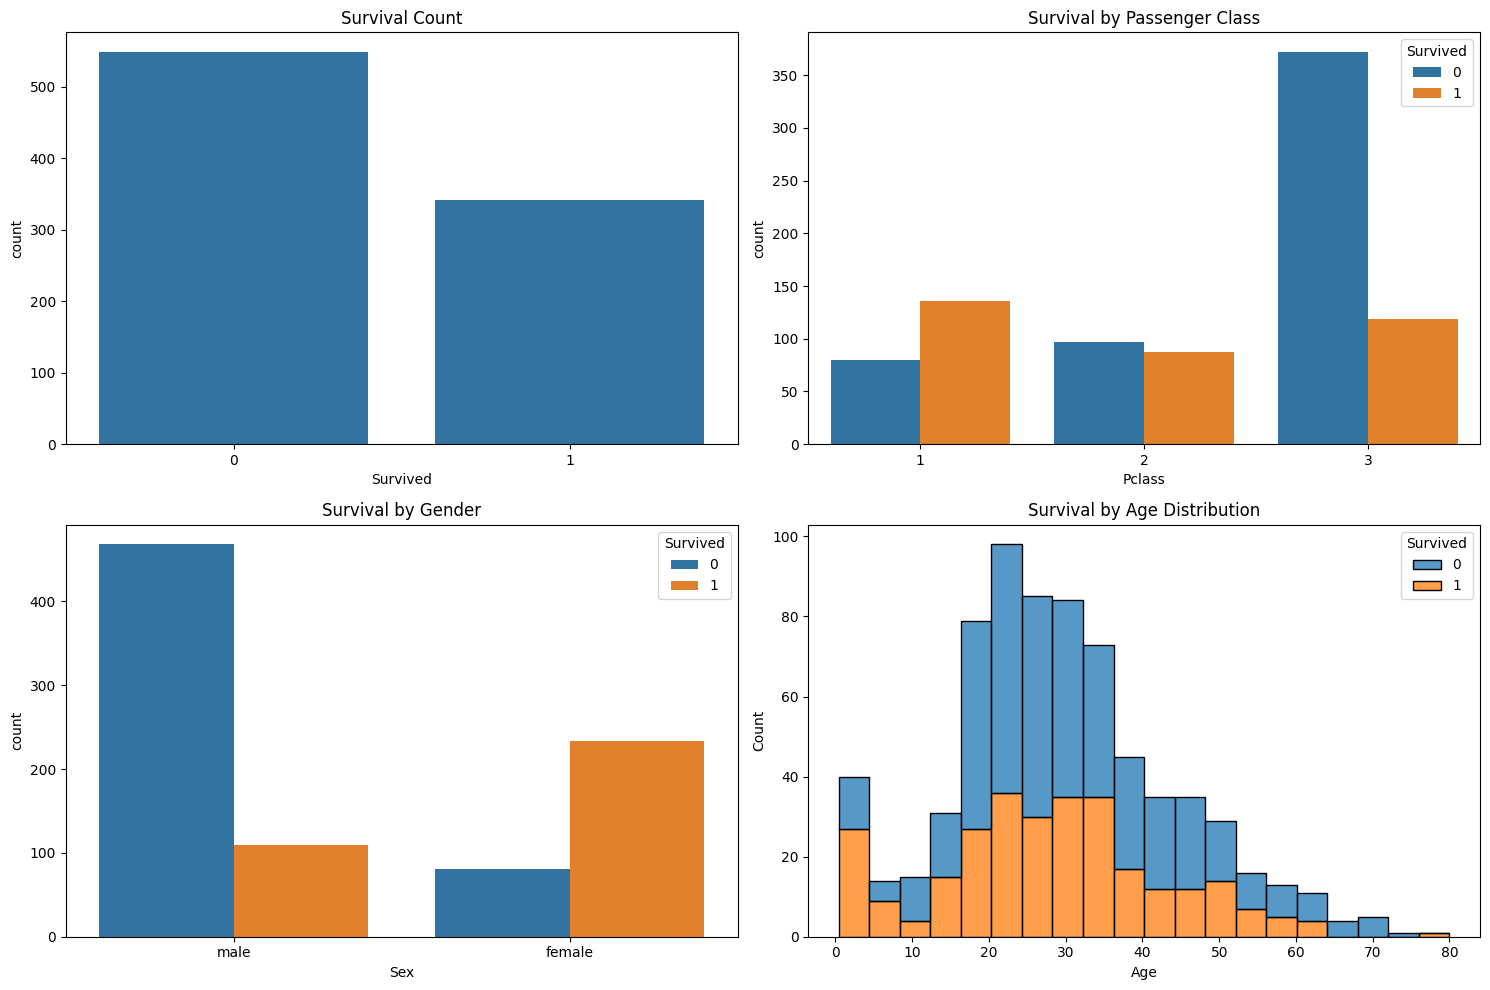

In [5]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='Survived', data=df)
plt.title('Survival Count')

plt.subplot(2, 2, 2)
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival by Passenger Class')

plt.subplot(2, 2, 3)
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Survival by Gender')

plt.subplot(2, 2, 4)
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack', bins=20)
plt.title('Survival by Age Distribution')

plt.tight_layout()
plt.show()

In [6]:
def preprocess_data(data):
    # Create family size feature
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

    # Create is alone feature
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

    # Extract titles from names
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don',
                                           'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

    # Fill missing ages based on title
    title_ages = data.groupby('Title')['Age'].median()
    for title in data['Title'].unique():
        data.loc[(data['Age'].isnull()) & (data['Title'] == title), 'Age'] = title_ages[title]

    # Fill missing embarked with most common value
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

    # Fill missing fare with median for passenger class
    data['Fare'].fillna(data.groupby('Pclass')['Fare'].transform('median'), inplace=True)

    # Drop columns we won't use
    data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

    return data

In [7]:
df_processed = preprocess_data(df.copy())

<ipython-input-6-02260c8b5571>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
<ipython-input-6-02260c8b5571>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [8]:
def encode_features(data):
    le = LabelEncoder()
    data['Sex'] = le.fit_transform(data['Sex'])
    data['Embarked'] = le.fit_transform(data['Embarked'])
    data['Title'] = le.fit_transform(data['Title'])
    return data

In [9]:
df_encoded = encode_features(df_processed.copy())

In [10]:
df_encoded.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title
0,0,3,1,22.0,1,0,7.2500,2,2,0,2
1,1,1,0,38.0,1,0,71.2833,0,2,0,3
2,1,3,0,26.0,0,0,7.9250,2,1,1,1
3,1,1,0,35.0,1,0,53.1000,2,2,0,3
4,0,3,1,35.0,0,0,8.0500,2,1,1,2


In [11]:
X = df_encoded.drop('Survived', axis=1)
y = df_encoded['Survived']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
num_cols = ['Age', 'Fare', 'FamilySize']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [14]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
y_pred = rf_model.predict(X_test)

In [16]:
print("Random Forest Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Random Forest Model Performance:
Accuracy: 0.84

Confusion Matrix:
[[92 13]
 [15 59]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       105
           1       0.82      0.80      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



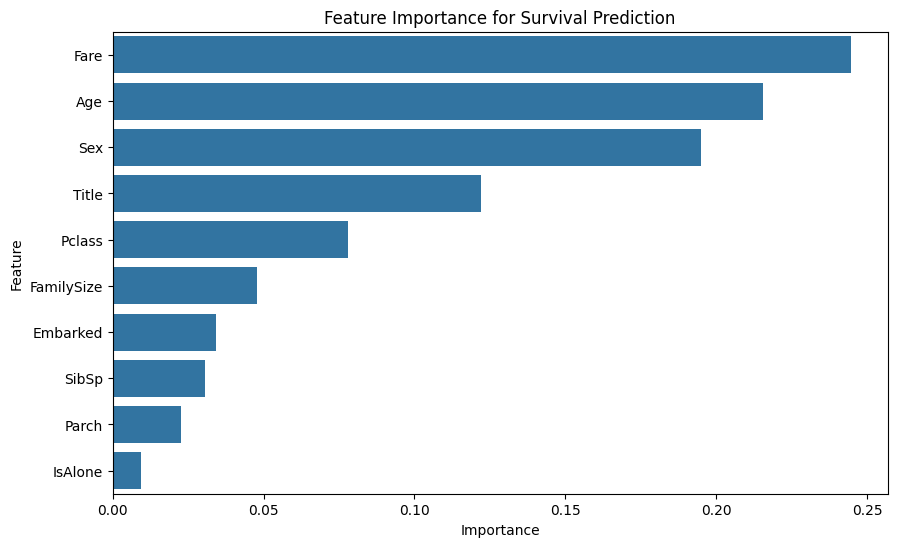

In [17]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Survival Prediction')
plt.show()

In [18]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [19]:
y_pred_xgb = xgb_model.predict(X_test)

In [20]:
print("\nXGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Model Performance:
Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       105
           1       0.79      0.81      0.80        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



In [37]:
def predict_survival(model, passenger_data, scaler=scaler):
    """
    Predict Titanic survival for a new passenger using a trained model.

    Parameters:
    - model: Trained classification model (e.g., RandomForest, XGBoost)
    - passenger_data: dict with keys like Pclass, Sex, Age, SibSp, Parch, Fare, Embarked
    - scaler: Fitted StandardScaler used on training data

    Returns:
    - str: Prediction with confidence
    """

    # Required fields with defaults
    # default_passenger = {
    #     'Pclass': 3,
    #     'Sex': 'male',
    #     'Age': 30,
    #     'SibSp': 0,
    #     'Parch': 0,
    #     'Fare': 20,
    #     'Embarked': 'S',
    #     'Name': 'Test Mr.',
    #     'Ticket': '00000',
    #     'Cabin': 'C85',
    #     'PassengerId': 9999
    # }

    # # Fill in missing values with defaults
    # for key, value in default_passenger.items():
    #     if key not in passenger_data:
    #         passenger_data[key] = value

    # Create DataFrame
    passenger_df = pd.DataFrame([passenger_data])

    # Preprocess and encode
    processed = preprocess_data(passenger_df)
    encoded = encode_features(processed)

    # Scale numeric features
    num_cols = ['Age', 'Fare', 'FamilySize']
    encoded[num_cols] = scaler.transform(encoded[num_cols])

    # Predict
    prediction = model.predict(encoded)
    proba = model.predict_proba(encoded)

    result = "Survived" if prediction[0] == 1 else "Did Not Survive"
    confidence = proba[0][prediction[0]]

    return f"Prediction: {result} (Confidence: {confidence:.2%})"


In [46]:
new_passenger = {
    'Pclass': 3,
    'Sex': 'female',
    'Age': 30,
    'SibSp': 0,
    'Parch': 0,
    'Fare': 20,
    'Embarked': 'S',
    'Name': 'Test Ms.',
    'Ticket': '00000',
    'Cabin': 'C85',
    'PassengerId': 9999
}

print(predict_survival(rf_model, new_passenger))
print(predict_survival(xgb_model, new_passenger))

Prediction: Survived (Confidence: 53.87%)
Prediction: Survived (Confidence: 84.15%)


<ipython-input-6-02260c8b5571>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
<ipython-input-6-02260c8b5571>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace